In [68]:
from collections import Counter
import json
import requests, sys, os
import time
import xmltodict

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [69]:
df = pd.read_csv("results/cnv_phenotypes.csv")
df["Phenotype"] = df["Phenotype"].apply(lambda row: "Converter" if row == " Converter" else row)
df["Phenotype"] = df["Phenotype"].str.lower()
df.dropna(subset=["Protein_coding_genes"], inplace=True)
df.reset_index(drop=True, inplace=True)
df["Start"] = df["Start"].astype(int)
df["End"] = df["End"].astype(int)
df["CNV_length"] = df["End"] - df["Start"]

phenotypes = ["nuhr", "uhr", "fep", "converter", "non_converter"]

for phenotype in phenotypes:
    unique_ids = df[df["Phenotype"] == phenotype]["ID_WGS"].unique()
    print(f"Number of {phenotype.upper()}: {len(unique_ids)}")


Number of NUHR: 7
Number of UHR: 22
Number of FEP: 249
Number of CONVERTER: 46
Number of NON_CONVERTER: 63


## DEL vs DUP between FEP+CONV and NON_CONV

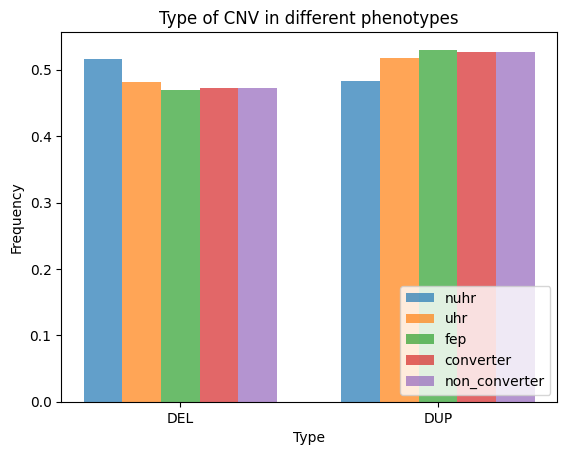

In [70]:
cnv_types = ["DEL", "DUP"]
results = {}

# Calculate frequencies for each label and category
for phenotype in phenotypes:
    for cnv_type in cnv_types:
        key = f"{phenotype}_{cnv_type}"
        count = sum((df["Type"] == cnv_type) & df["Phenotype"].isin([phenotype])) / len(df[df["Phenotype"].isin([phenotype])])
        results[key] = count

cnv_counts = {phenotype: [results[f"{phenotype}_{cnv_type}"] for cnv_type in cnv_types] for phenotype in phenotypes}


df_plot = pd.DataFrame(cnv_counts, index=cnv_types)
width = 0.15
fig, ax = plt.subplots()
for i, phenotype in enumerate(phenotypes):
    bars = ax.bar(np.arange(len(cnv_types)) + i * width, df_plot[phenotype], width, alpha=0.7, label=phenotype)

ax.set_xlabel("Type")
ax.set_ylabel("Frequency")
ax.set_title("Type of CNV in different phenotypes")
ax.set_xticks(np.arange(len(cnv_types)) + width * (len(phenotypes) - 1) / 2)
ax.set_xticklabels(cnv_types)
ax.legend(loc="lower right")

plt.show()

In [71]:
for cnv_type in cnv_types:
    for phenotype in phenotypes:
        type_mask = df["Type"] == cnv_type
        phenotype_mask = df["Phenotype"] == phenotype
        filtered_df = df[type_mask & phenotype_mask]
        
        count = len(filtered_df)
        min_length = filtered_df["CNV_length"].min()
        max_length = filtered_df["CNV_length"].max()
        average_length = filtered_df["CNV_length"].mean()
        sd_length = filtered_df["CNV_length"].std()
        
        print(f"CNV Type: {cnv_type}, Phenotype: {phenotype.upper()}")
        print(f"Number of CNV: {count}")
        print(f"Minimum Length: {min_length}")
        print(f"Maximum Length: {max_length}")
        print(f"Average Length: {average_length:.2f}")
        print(f"Standard Deviation: {sd_length:.2f}")
        print()

CNV Type: DEL, Phenotype: NUHR
Number of CNV: 172
Minimum Length: 10016
Maximum Length: 269621
Average Length: 32160.74
Standard Deviation: 33945.24

CNV Type: DEL, Phenotype: UHR
Number of CNV: 498
Minimum Length: 9999
Maximum Length: 256376
Average Length: 31866.58
Standard Deviation: 28614.09

CNV Type: DEL, Phenotype: FEP
Number of CNV: 5574
Minimum Length: 9999
Maximum Length: 2379038
Average Length: 34997.00
Standard Deviation: 50987.75

CNV Type: DEL, Phenotype: CONVERTER
Number of CNV: 1001
Minimum Length: 10009
Maximum Length: 366348
Average Length: 32870.82
Standard Deviation: 32487.62

CNV Type: DEL, Phenotype: NON_CONVERTER
Number of CNV: 1444
Minimum Length: 10016
Maximum Length: 1633562
Average Length: 35962.13
Standard Deviation: 57826.74

CNV Type: DUP, Phenotype: NUHR
Number of CNV: 161
Minimum Length: 10091
Maximum Length: 345024
Average Length: 62537.04
Standard Deviation: 75545.29

CNV Type: DUP, Phenotype: UHR
Number of CNV: 536
Minimum Length: 10091
Maximum Length

## Pathogenic CNV between FEP+CONV and NON_CONV

In [72]:
pathogenic = ["Pathogenic", "Likely_pathogenic"]

for cnv_type in cnv_types:
    for phenotype in phenotypes:
        type_mask = df["Type"] == cnv_type
        phenotype_mask = df["Phenotype"] == phenotype
        classification_mask = df["Classification"].isin(pathogenic)

        filtered_df = df[type_mask & phenotype_mask & classification_mask]

        count = len(filtered_df)
        print(f"CNV Type: {cnv_type}, Phenotype: {phenotype.upper()}")
        print(f"Number of Pathogenic or Likely Pathogenic CNV: {count}")


CNV Type: DEL, Phenotype: NUHR
Number of Pathogenic or Likely Pathogenic CNV: 0
CNV Type: DEL, Phenotype: UHR
Number of Pathogenic or Likely Pathogenic CNV: 0
CNV Type: DEL, Phenotype: FEP
Number of Pathogenic or Likely Pathogenic CNV: 4
CNV Type: DEL, Phenotype: CONVERTER
Number of Pathogenic or Likely Pathogenic CNV: 0
CNV Type: DEL, Phenotype: NON_CONVERTER
Number of Pathogenic or Likely Pathogenic CNV: 1
CNV Type: DUP, Phenotype: NUHR
Number of Pathogenic or Likely Pathogenic CNV: 0
CNV Type: DUP, Phenotype: UHR
Number of Pathogenic or Likely Pathogenic CNV: 0
CNV Type: DUP, Phenotype: FEP
Number of Pathogenic or Likely Pathogenic CNV: 0
CNV Type: DUP, Phenotype: CONVERTER
Number of Pathogenic or Likely Pathogenic CNV: 0
CNV Type: DUP, Phenotype: NON_CONVERTER
Number of Pathogenic or Likely Pathogenic CNV: 0


## Rares CNV between FEP+CONV and NON_CONV

In [372]:
def is_not_rare_cnv(row, cnv_df):

    genes = set(row["Protein_coding_genes"].split(","))
    num_shared_genes = cnv_df["unique_genes"].apply(lambda x: len(genes.intersection(x)) > 0).sum()
    
    return num_shared_genes >= 3 and len(genes) < 3

mask_not_rare = df.apply(lambda x: is_not_rare_cnv(x, df), axis=1)

In [373]:
df["unique_genes"] = df["Protein_coding_genes"].str.split(",").apply(set)
df.drop(df[mask_not_rare].index, inplace=True)
df.drop(columns=["unique_genes"], inplace=True)
df.drop(df[df["Classification"] == "Benign"].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [203]:
df.to_csv("results/cnv_rares.csv", index=False)

In [78]:
df = pd.read_csv("results/cnv_rares.csv")
df["Phenotype"] = df["Phenotype"].apply(lambda row: "Converter" if row == " Converter" else row)
df["Phenotype"] = df["Phenotype"].str.lower()
df.dropna(subset=["Protein_coding_genes"], inplace=True)
df.reset_index(drop=True, inplace=True)
df["Start"] = df["Start"].astype(int)
df["End"] = df["End"].astype(int)

In [88]:
for cnv_type in cnv_types:
    for phenotype in phenotypes:
        type_mask = df["Type"] == cnv_type
        phenotype_mask = df["Phenotype"] == phenotype
        
        filtered_df = df[type_mask & phenotype_mask]
        
        count = len(filtered_df)
        avg_length = filtered_df["CNV_length"].mean()
        sd_length = filtered_df["CNV_length"].std()
        min_length = filtered_df["CNV_length"].min()
        max_length = filtered_df["CNV_length"].max()

        print(f"CNV Type: {cnv_type}, Phenotype: {phenotype.upper()}")
        print(f"Number of Rare {cnv_type}: {count}")
        print(f"Average Length: {avg_length:.2f}")
        print(f"SD Length: {sd_length:.2f}")
        print(f"Min Length: {min_length:.2f}")
        print(f"Max Length: {max_length:.0f}")


CNV Type: DEL, Phenotype: NUHR
Number of Rare DEL: 0
Average Length: nan
SD Length: nan
Min Length: nan
Max Length: nan
CNV Type: DEL, Phenotype: UHR
Number of Rare DEL: 0
Average Length: nan
SD Length: nan
Min Length: nan
Max Length: nan
CNV Type: DEL, Phenotype: FEP
Number of Rare DEL: 323
Average Length: 57844.47
SD Length: 164876.84
Min Length: 9999.00
Max Length: 2379038
CNV Type: DEL, Phenotype: CONVERTER
Number of Rare DEL: 47
Average Length: 46211.66
SD Length: 63909.85
Min Length: 10124.00
Max Length: 310301
CNV Type: DEL, Phenotype: NON_CONVERTER
Number of Rare DEL: 76
Average Length: 75747.37
SD Length: 208722.29
Min Length: 10173.00
Max Length: 1633562
CNV Type: DUP, Phenotype: NUHR
Number of Rare DUP: 0
Average Length: nan
SD Length: nan
Min Length: nan
Max Length: nan
CNV Type: DUP, Phenotype: UHR
Number of Rare DUP: 0
Average Length: nan
SD Length: nan
Min Length: nan
Max Length: nan
CNV Type: DUP, Phenotype: FEP
Number of Rare DUP: 441
Average Length: 114051.78
SD Lengt

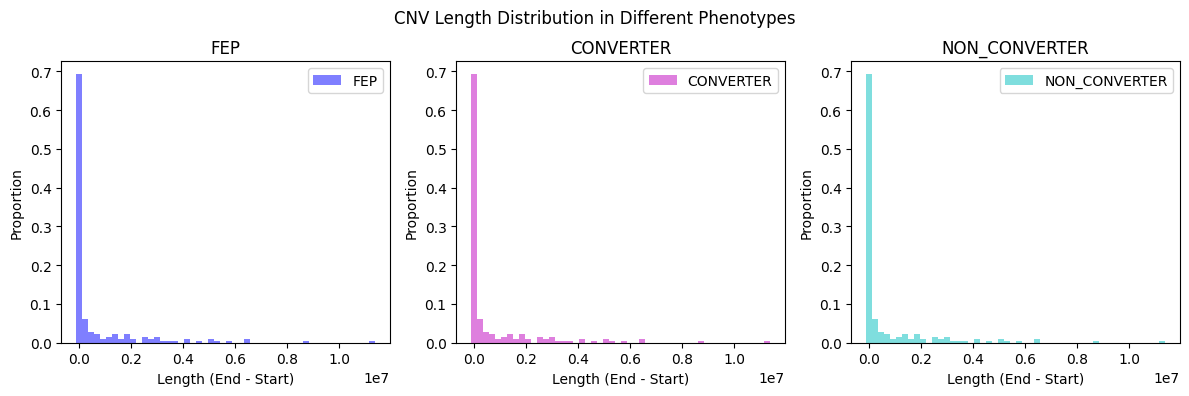

In [86]:
phenotypes_rare = ["fep", "converter", "non_converter"]
color_map = {
    "fep": "b",
    "converter": "m",
    "non_converter": "c"
}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("CNV Length Distribution in Different Phenotypes")

for i, phenotype in enumerate(phenotypes_rare):
    ax = axes[i]

    hist, bins = np.histogram(df[phenotype_mask]["CNV_length"], bins=50)
    total = len(df[phenotype_mask])
    proportions = hist / total

    ax.bar(bins[:-1], proportions, width=(bins[1]-bins[0]), color=color_map[phenotype], alpha=0.5, label=phenotype.upper())
    ax.set_xlabel("Length (End - Start)")
    ax.set_ylabel("Proportion")
    ax.set_title(f"{phenotype.upper()}")
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

In [90]:
# Threshold for long CNVs
threshold = 400_000

for cnv_type in cnv_types:
    for phenotype in phenotypes_rare:
        type_mask = df["Type"] == cnv_type
        phenotype_mask = df["Phenotype"] == phenotype
        long_mask = df["CNV_length"] > threshold

        filtered_df = df[type_mask & phenotype_mask & long_mask]

        count = len(filtered_df)
        avg_length = filtered_df["CNV_length"].mean()
        sd_length = filtered_df["CNV_length"].std()
        min_length = filtered_df["CNV_length"].min()
        max_length = filtered_df["CNV_length"].max()

        print(f"CNV Type: {cnv_type}, Phenotype: {phenotype.upper()}")
        print(f"Number of Rare {cnv_type}: {count}")
        print(f"Average Length: {avg_length:.2f}")
        print(f"SD Length: {sd_length:.2f}")
        print(f"Min Length: {min_length:.2f}")
        print(f"Max Length: {max_length:.0f}")

CNV Type: DEL, Phenotype: FEP
Number of Rare DEL: 10
Average Length: 746497.40
SD Length: 585158.96
Min Length: 400384.00
Max Length: 2379038
CNV Type: DEL, Phenotype: CONVERTER
Number of Rare DEL: 0
Average Length: nan
SD Length: nan
Min Length: nan
Max Length: nan
CNV Type: DEL, Phenotype: NON_CONVERTER
Number of Rare DEL: 3
Average Length: 942566.00
SD Length: 602544.68
Min Length: 526687.00
Max Length: 1633562
CNV Type: DUP, Phenotype: FEP
Number of Rare DUP: 27
Average Length: 701337.19
SD Length: 305498.30
Min Length: 404366.00
Max Length: 1646751
CNV Type: DUP, Phenotype: CONVERTER
Number of Rare DUP: 7
Average Length: 1052771.57
SD Length: 1052624.26
Min Length: 455694.00
Max Length: 3404960
CNV Type: DUP, Phenotype: NON_CONVERTER
Number of Rare DUP: 52
Average Length: 2659424.15
SD Length: 2257336.69
Min Length: 429567.00
Max Length: 11481588


## Brain genes in FEP+CONV and NON_CONV

In [144]:
unique_genes = set()
df["Protein_coding_genes"].apply(lambda x: unique_genes.update(x.split(", ")))
unique_genes = list(unique_genes)

In [ ]:
gene_id = {}

In [100]:
api_key = "5c60f73cd9bc7bce4e4a8d496e3dde241709"
db = "gene"
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
retmode = "xml"

for gene_name in tqdm(unique_genes):
    if gene_name in gene_id:
        continue
    term = f"(Homo+sapiens%5BOrganism%5D)+AND+{gene_name}%5BGene+Name%5D"
    query_url = (
            f"{base_url}/esearch.fcgi?db={db}&term={term}&retmode={retmode}&api_key={api_key}"
    )
    response = requests.get(query_url)
    if response.status_code != 200:
        print(f"Error with {gene_name}")
    else:
        xml_content = response.content
        xml_content_dict = xmltodict.parse(xml_content)
        gene_id_list = xml_content_dict["eSearchResult"]["IdList"]["Id"]
        gene_id[gene_name] = gene_id_list

100%|██████████| 2059/2059 [00:36<00:00, 56.17it/s]  


In [99]:
unique_genes.remove("LOC150051")
unique_genes.append("TIAM1-AS1")

In [98]:
unique_genes.remove("LOC100130520")
unique_genes.append("CD300H")

In [194]:
filename = "results/gene_ids.json"

with open(filename, "w") as json_file:
    json.dump(gene_id, json_file)


In [145]:
with open("results/gene_ids.json", "r") as json_file:
    gene_id = json.load(json_file)

In [5]:
gene_expression = {}

In [45]:
#example : https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=gene&id=10149&retmode=xml

api_key = "5c60f73cd9bc7bce4e4a8d496e3dde241709"
db = "gene"
base_url = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "xml"

for gene in tqdm(gene_id_list):
    
    if gene in gene_expression:
        continue
    
    for id in gene_id[gene]:
        
        query_url = (
            f"{base_url}/efetch.fcgi?db={db}&id={str(id)}"
            f"&retmode={retmode}&rettype=abstract&api_key={api_key}"
        )
        
        response = requests.get(query_url)
        
        if response.status_code == 200:
            xml_content = response.content
            xml_content_dict = xmltodict.parse(xml_content)
            info = xml_content_dict['Entrezgene-Set']['Entrezgene']['Entrezgene_comments']['Gene-commentary']
            for dict_info in info:
                if 'Gene-commentary_heading' in dict_info.keys():
                    if dict_info['Gene-commentary_heading'] == 'Representative Expression':
                        for comment in dict_info["Gene-commentary_comment"]['Gene-commentary']:
                            if comment["Gene-commentary_label"] == "Tissue List":
                                gene_expression[gene] = comment['Gene-commentary_text']
            break 
        
    if gene not in gene_expression:
        print(f"Error {response.status_code} with {gene}")


  0%|          | 1/322 [00:00<03:20,  1.60it/s]

Error 200 with FAM25E


  1%|          | 2/322 [00:01<03:10,  1.68it/s]

Error 200 with PTCHD4


  1%|          | 3/322 [00:01<03:08,  1.69it/s]

Error 200 with STPG2


  1%|          | 4/322 [00:02<03:04,  1.72it/s]

Error 200 with OR2T11


  2%|▏         | 5/322 [00:02<03:02,  1.74it/s]

Error 200 with TRMT12


  2%|▏         | 5/322 [00:03<03:29,  1.51it/s]


KeyboardInterrupt: 

In [29]:
filename = "results/gene_expression.json"

with open(filename, "w") as json_file:
    json.dump(gene_expression, json_file)

In [291]:
with open("results/gene_expression.json", 'r') as json_file:
    gene_expression = json.load(json_file)

In [292]:
df["Tissue_expression"] = df["Protein_coding_genes"].apply(lambda x: set(expression.strip() for gene in x.split(", ") if gene in gene_expression for expression in gene_expression[gene].split(";")))

In [96]:
for cnv_type in cnv_types:
    for phenotype in phenotypes_rare:
        type_mask = df["Type"] == cnv_type
        phenotype_mask = df["Phenotype"] == phenotype
        brain_mask = df["Tissue_expression"].apply(lambda x: "brain" in str(x))

        filtered_df = df[type_mask & phenotype_mask & brain_mask]

        count = len(filtered_df)
        avg_length = filtered_df["CNV_length"].mean()
        sd_length = filtered_df["CNV_length"].std()
        min_length = filtered_df["CNV_length"].min()
        max_length = filtered_df["CNV_length"].max()

        print(f"CNV Type: {cnv_type}, Phenotype: {phenotype.upper()}")
        print(f"Number of Rare {cnv_type}: {count}")
        print(f"Average Length: {avg_length:.2f}")
        print(f"SD Length: {sd_length:.2f}")
        print(f"Min Length: {min_length:.2f}")
        print(f"Max Length: {max_length:.0f}")

CNV Type: DEL, Phenotype: FEP
Number of Rare DEL: 219
Average Length: 67482.26
SD Length: 196072.98
Min Length: 9999.00
Max Length: 2379038
CNV Type: DEL, Phenotype: CONVERTER
Number of Rare DEL: 29
Average Length: 48469.69
SD Length: 73048.75
Min Length: 10124.00
Max Length: 310301
CNV Type: DEL, Phenotype: NON_CONVERTER
Number of Rare DEL: 45
Average Length: 97025.67
SD Length: 266222.09
Min Length: 10495.00
Max Length: 1633562
CNV Type: DUP, Phenotype: FEP
Number of Rare DUP: 348
Average Length: 114963.94
SD Length: 187291.94
Min Length: 10115.00
Max Length: 1646751
CNV Type: DUP, Phenotype: CONVERTER
Number of Rare DUP: 50
Average Length: 106335.06
SD Length: 181987.99
Min Length: 10890.00
Max Length: 907796
CNV Type: DUP, Phenotype: NON_CONVERTER
Number of Rare DUP: 110
Average Length: 1253044.82
SD Length: 2018210.90
Min Length: 10765.00
Max Length: 11481588


In [302]:
def remove_empty_strings(s):
    return {item for item in s if item != ""}

df['Tissue_expression'] = df['Tissue_expression'].apply(remove_empty_strings)
df['Tissue_expression'] = df['Tissue_expression'].apply(lambda x: ", ".join(x))


In [229]:
df.to_csv("results/cnv_rares.csv", index=False)

## Statistical analysis

In [315]:
data = {
    "FEP + CONV": [6552, 7381, 4, 0, 370, 56367, 10, 248, 512, 120151, 34, 398],
    "NCONV": [1444, 1611, 1, 0, 76, 75747, 3, 45, 135, 1072063, 52, 110]
}

index = [
    "nb_DEL",
    "nb_DUP",
    "nb_DEL_patho",
    "nb_DUP_patho",
    "nb_DEL_VUS_rares",
    "DEL_VUS_rares_size",
    "nb_DEL_VUS_rares_size_>_400kb",
    "nb_DEL_VUS_rares_in_brain",
    "nb_DUP_VUS_rares",
    "DUP_VUS_rares_size",
    "nb_DUP_VUS_rares_size_>_400kb",
    "nb_DUP_VUS_rares_in_brain",
]

df_stat = pd.DataFrame(data, index=index)
df_stat = df_stat.transpose()

In [316]:
columns = df_stat.columns.to_list()
columns.remove("DEL_VUS_rares_size")
columns.remove("DUP_VUS_rares_size")

In [323]:
import scipy.stats as stats
import statsmodels.api as sm

total_cnv_conv = 13933
total_cnv_non_conv = 3055

p_values = []

for column in columns:
    
    count_conv = int(df_stat[column]["FEP + CONV"])
    count_non_conv = int(df_stat[column]["NCONV"])

    # Z-test for proportions
    _, p_value = sm.stats.proportions_ztest([count_conv, count_non_conv], 
                                                  [total_cnv_conv, total_cnv_non_conv])
        
    p_values.append(p_value)

#_, adjusted_p_values, _, _ = sm.stats.multipletests(p_values, method="fdr_bh")

for i, p in enumerate(p_values):
    df_stat.at["p-value", columns[i]] = p
    df_stat.at["DIFF", columns[i]] = p < 0.05

In [383]:
df = pd.read_csv("results/cnv_rares.csv")

In [309]:
del_conv_mask = (df["Type"] == "DEL") & (df["Phenotype"].isin(converters))
dup_conv_mask = (df["Type"] == "DUP") & (df["Phenotype"].isin(converters))
del_non_conv_mask = (df["Type"] == "DEL") & (df["Phenotype"].isin(non_converters))
dup_non_conv_mask = (df["Type"] == "DUP") & (df["Phenotype"].isin(non_converters))

In [318]:
del_conv_data = df[del_conv_mask]["CNV_length"].to_list()
del_non_conv_data = df[del_non_conv_mask]["CNV_length"].to_list()
dup_conv_data = df[dup_conv_mask]["CNV_length"].to_list()
dup_non_conv_data = df[dup_non_conv_mask]["CNV_length"].to_list()

_, p_value_del = stats.ttest_ind(del_conv_data, del_non_conv_data)
_, p_value_dup = stats.ttest_ind(dup_conv_data, dup_non_conv_data)

df_stat.at["p-value", "DEL_VUS_rares_size"] = p_value_del
df_stat.at["DIFF", "DEL_VUS_rares_size"] = p_value_del < 0.05
df_stat.at["p-value", "DUP_VUS_rares_size"] = p_value_dup
df_stat.at["DIFF", "DUP_VUS_rares_size"] = p_value_dup < 0.05


/tmp/ipykernel_674/1724715251.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_stat.at["DIFF", "DEL_VUS_rares_size"] = p_value_del < 0.05
/tmp/ipykernel_674/1724715251.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_stat.at["DIFF", "DUP_VUS_rares_size"] = p_value_dup < 0.05


In [319]:
df_stat.to_csv("results/stats.csv")

,nb_DEL,nb_DUP,nb_DEL_patho,nb_DUP_patho,nb_DEL_VUS_rares,DEL_VUS_rares_size,nb_DEL_VUS_rares_size_>_400kb,nb_DEL_VUS_rares_in_brain,nb_DUP_VUS_rares,DUP_VUS_rares_size,nb_DUP_VUS_rares_size_>_400kb,nb_DUP_VUS_rares_in_brain
FEP + CONV,6552.0,7381.0,4.0,0.0,370.0,56367.0,10.0,248.0,512.0,120151.0,34.0,398.0
NCONV,1444.0,1611.0,1.0,0.0,76.0,75747.0,3.0,45.0,135.0,1072063.0,52.0,110.0
p-value,0.808458,0.808458,0.906513,NaN,0.599267,0.354002,0.632374,0.237935,0.051608,0.0,0.0,0.028747
DIFF,False,False,False,False,False,False,False,False,False,True,True,True


## Another stats for the table in article

In [325]:
df = pd.read_csv("results/cnv_phenotypes.csv")
df.dropna(subset=["Protein_coding_genes"], inplace=True)
df.reset_index(drop=True, inplace=True)
df["Start"] = df["Start"].astype(int)
df["End"] = df["End"].astype(int)
df["CNV_length"] = df["End"] - df["Start"]

converters = ["FEP", "Converter"]
non_converters = ["Non_converter"]

# Drop UHR and NUHR
df = df[df["Phenotype"].isin(converters + non_converters)]